In [1]:
!pip install pyproj matplotlib


zsh:1: /Users/tommyluu/Documents/projects/naplab-to-nerfstudio/naplab-to-nerfstudio/venv/bin/pip: bad interpreter: /Users/tommyluu/Documents/projects/naplab-to-nerfstudio/venv/bin/python3.12: no such file or directory
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pyproj
import importlib
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
from camera.camera import Camera
from dataclasses import dataclass
importlib.reload(sys.modules['camera'])
importlib.reload(sys.modules['camera.camera'])


<module 'camera.camera' from '/Users/tommyluu/Documents/projects/naplab-to-nerfstudio/naplab-to-nerfstudio/camera/camera.py'>

In [3]:
transformer = pyproj.Transformer.from_crs("4326", "32633", always_xy=True) # GPS to UTM33

In [4]:
def convert_to_utm(lat, lon, alt):
    """Convert latitude, longitude, and altitude to UTM coordinates."""
    utm_x, utm_y, utm_z = transformer.transform(lon, lat, alt)
    return utm_x, utm_y, utm_z


In [5]:
@dataclass
class CarData:
    timestamp: int
    position: np.array
    direction: np.array
    
    def get_rotation_matrix(self):
        # rotates from world space to car space
        main_direction = np.array([1, 0, 0])
        a, b = self.direction, main_direction
        v = np.cross(a, b)
        c = np.dot(a, b)
        s = np.linalg.norm(v)
        kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
        rotation_matrix = np.eye(3) + kmat + np.dot(kmat, kmat) * ((1 - c) / (s ** 2))
        return rotation_matrix
    
    def get_translation_matrix(self):
        translation = np.zeros((4, 4))
        translation[3, 3] = 1
        translation[:3, 3] = self.position
        return translation
    
    def get_car_roll(self):
        # project xyz position to xy plane
        projection = np.array([self.position[0], self.position[1], 0])
        # angle between projection and position vector
        angle = np.arccos(np.dot(projection, self.position) / (np.linalg.norm(projection) * np.linalg.norm(self.position)))
        return angle
    
    def get_inverse_rotation_matrix(self):
        # rotates from car space to world space
        return np.linalg.inv(self.get_rotation_matrix())

In [6]:
def process_gps_data(file_path, verbose=False):
    coords = []
    timestamps = []
    """Process a file to read GPS data and convert it to UTM."""
    with open(file_path, 'r') as file:
        for line in file:
            # Check if line contains 'GPS[0]' and match the coordinate pattern, since GPS[0] and GPS[1] are the same
            if 'GPS[0]' in line:
                match = re.search(r"- ([\d]+) lat: ([\d\.]+) lon: ([\d\.]+) alt: ([\d\.]+)", line)
                if match:
                    timestamp = int(match.group(1))
                    lat = float(match.group(2))
                    lon = float(match.group(3))
                    alt = float(match.group(4))
                    utm_x, utm_y, utm_z = convert_to_utm(lat, lon, alt)
                    if verbose:
                        print(f"Original: timestamp={timestamp} lat={lat}, lon={lon}, alt={alt}")
                        print(f"Converted to UTM: X={utm_x}, Y={utm_y}, Z={utm_z}")
                    coords.append(np.array([utm_x, utm_y, utm_z]))
                    timestamps.append(timestamp)
    return timestamps, np.stack(coords)

def append_direction(coords: np.ndarray):
    dirs = coords[1:] - coords[:-1]
    dirs = np.concatenate([dirs, dirs[-1].reshape(1,3)])
    return dirs / np.linalg.norm(dirs, axis=1).reshape(-1,1)


def process_car_data(file_path, verbose=False) -> list[CarData]:
    ts, coords = process_gps_data(file_path, verbose)
    dirs = append_direction(coords)
    cardatas = []
    for i in range(len(coords)):
        cardatas.append(CarData(ts[i], coords[i], np.array(dirs[i]) / np.linalg.norm(dirs[i])))
    return cardatas

In [7]:
def plot_3d(series_list: list[list], labels: list[str], figsize=(5, 5)):
    """Plot 3D coordinates."""
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    colorpallet = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for s in series_list:
        x = [data[0] for data in s]
        y = [data[1] for data in s]
        z = [data[2] for data in s]
        ax.plot(x, y, z, marker='.', markersize=0.5, color=colorpallet.pop(0))
        
    plt.legend(labels)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def plot_2d(series_list: list[list], labels: list[str], figsize=(5, 5)):
    """Plot 2D coordinates."""
    colorpallet = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure(figsize=figsize)
    for s in series_list:
        x = [data[0] for data in s]
        y = [data[1] for data in s]
        plt.plot(x, y, marker='.', markersize=0.5, color=colorpallet.pop(0))
    
    plt.legend(labels)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D plot of XY coordinates')
    plt.show()


In [8]:
c1_front_60_single = Camera("C1_front60Single", 846.863159, 670.665466, 1208, 1920,  #right cam
                    t=[
                        1.8162150382995605,
                        0.22106018662452698,
                        1.5156701803207397
                    ], 
                    roll_pitch_yaw=[
                        1.6242992877960205,
                        2.82977557182312,
                        2.152301788330078
                    ])

c7_l2 = Camera("C7_L2", 1187.267212, 632.114624, 1208, 1920, t=[ # left side cam
                        2.072967767715454,
                        0.9314326643943787,
                        1.173095703125
                    ],
                    roll_pitch_yaw=[ # wrong
                        -1.6490494012832642,
                        2.6054768562316895,
                        -6.683704853057861
                    ])

c5_r1 = Camera("C5_R1", 965.822693, 649.506042, 1208, 1920, t=[1.933815360069275, -0.9714699983596802, 1.1585912704467773], roll_pitch_yaw=[
            2.778383255004883, -1.005295991897583, -131.37277221679688
          ])

print(c1_front_60_single.get_camera_intrinsics())

{'camera_model': 'OPENCV', 'fl_x': 1662.7687752661227, 'fl_y': 1046.1586877716022, 'cx': 846.863159, 'cy': 670.665466, 'w': 1920, 'h': 1208, 'k1': 0, 'k2': 0, 'p1': 0, 'p2': 0}


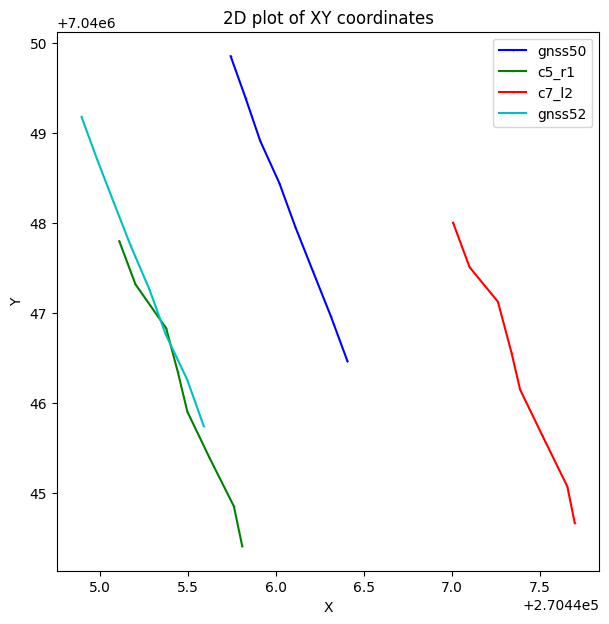

In [9]:

car_data50 = process_car_data("./Trip094/gnss094_50.txt")
car_data52 = process_car_data("./Trip094/gnss094_52.txt")

utmFrom50 = [coord.position for coord in car_data50]
utmFrom52 = [coord.position for coord in car_data52]
cam1_pos = [c5_r1.get_camera_position(cd.position, cd.get_inverse_rotation_matrix()) for cd in car_data50]
cam2_pos = [c7_l2.get_camera_position(cd.position, cd.get_inverse_rotation_matrix()) for cd in car_data50]
max_index = 8
plot_2d([utmFrom50[:max_index], cam1_pos[:max_index], cam2_pos[:max_index], utmFrom52[:max_index]], labels=["gnss50", "c5_r1", "c7_l2", "gnss52"] ,figsize=(7, 7))



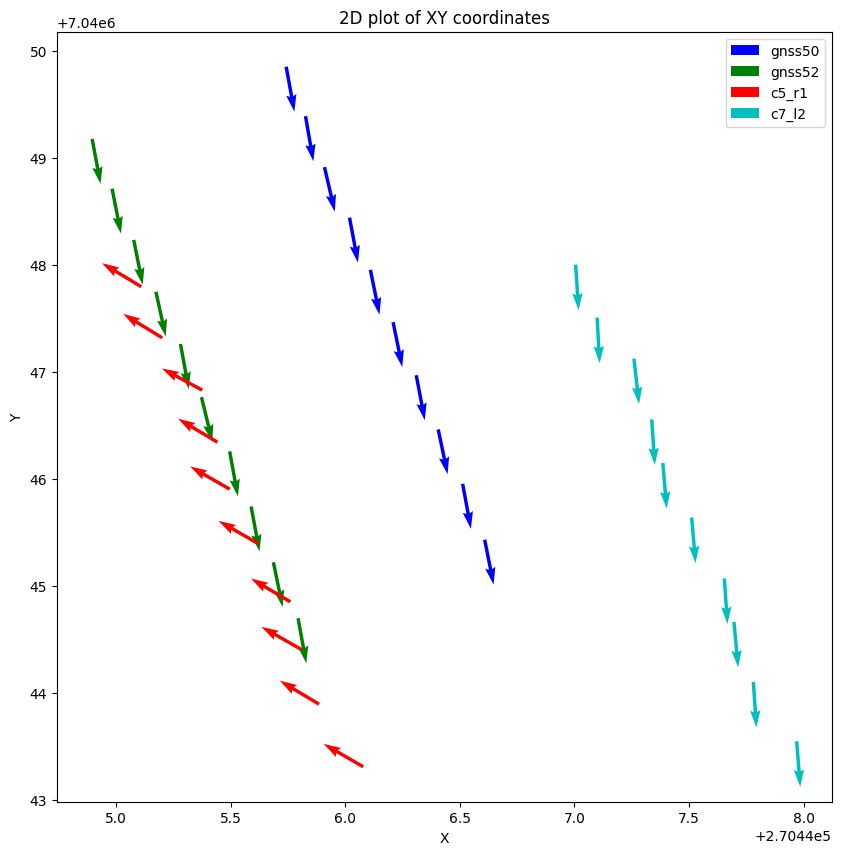

In [12]:
def plot_2d_v2(series_list: list[list], direction_vector_list: list[list], labels: list[str], figsize=(5, 5)):
    """Plot 2D coordinates."""
    colorpallet = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    plt.figure(figsize=figsize)
    for serie, dirs in zip(series_list, direction_vector_list):
        color = colorpallet.pop(0)
        x = [data[0] for data in serie]
        y = [data[1] for data in serie]
        
        V = np.array(dirs)
        #plt.plot(x, y, marker='.', markersize=0.5, color=color)
        #print(V)
        
        if len(V) > 0:
            plt.quiver(*[x, y], V[:, 0], V[:, 1], color=color, scale=3, units="xy", width=0.025)

    plt.legend(labels)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D plot of XY coordinates')
    plt.show()
    
max_index = 10
cardir = [cd.direction for cd in car_data50][:max_index]
cardir2 = [cd.direction for cd in car_data52][:max_index]
dir1 = [c5_r1.get_camera_direction_vector(cd.get_inverse_rotation_matrix()) for cd in car_data50][:max_index]
dir2 = [c7_l2.get_camera_direction_vector(cd.get_inverse_rotation_matrix()) for cd in car_data50][:max_index]


directions = [cardir, cardir2, dir1, dir2]
positions = [utmFrom50[:max_index], utmFrom52[:max_index], cam1_pos[:max_index], cam2_pos[:max_index]]
labels = ["gnss50", "gnss52", "c5_r1", "c7_l2"]
plot_2d_v2(positions, directions, labels, figsize=(10, 10))
